In [1]:
from pathlib import Path
from typing import Optional
from omegaconf import DictConfig

import logging
import torch
import matplotlib.pyplot as plt

from tabularbench.core.enums import DatasetSize, ModelName, Task
from tabularbench.core.get_model import get_model
from tabularbench.core.get_trainer import get_trainer

from tabularbench.data.dataset_openml import OpenMLDataset
from tabularbench.results.run_metrics import RunMetrics
from tabularbench.config.config_run import ConfigRun
from tabularbench.utils.paths_and_filenames import PATH_TO_OPENML_DATASETS
from tabularbench.utils.set_seed import set_seed
from tabularbench.core.run_experiment import run_experiment


cfg = ConfigRun(
    output_dir = "output_run_experiment",
    device = torch.device("cuda:4"),
    model_name = ModelName.FOUNDATION,
    seed = 0,
    task = Task.CLASSIFICATION,
    dataset_size = DatasetSize.MEDIUM,
    datafile_path=Path(PATH_TO_OPENML_DATASETS) / "whytrees_44156_MEDIUM.nc",
    openml_dataset_id = 44156,
    openml_dataset_name = "electricity",
    hyperparams = DictConfig({
        'n_features': 100,
        'n_classes': 10,
        'dim': 512,
        'n_layers': 12,
        'n_heads': 4,
        'attn_dropout': 0.0,
        'y_as_float_embedding': True,
        'linear_attention': False,
        'max_samples_support': 10000,
        'max_samples_query': 10000,
        'max_epochs': 0,
        'optimizer': 'adamw',
        'lr': 1.e-5,
        'weight_decay': 0,
        'lr_scheduler': False,
        'lr_scheduler_patience': 30,
        'early_stopping_patience': 40,
        'use_pretrained_weights': True,
        'n_ensembles': 1,
        'use_quantile_transformer': True,
        'use_feature_count_scaling': True
    })
)

tabpfn_weights = 'tabularbench/models/tabPFN/prior_diff_real_checkpoint_n_0_epoch_42.cpkt'
foundation_forest_weights = 'outputs_done/foundation_forest_big_300k/weights/model_step_300000.pt'
foundation_pfn_weights = 'outputs_done/foundation_tabpfn_big_300k/weights/model_step_300000.pt'
foundation_forest_128_weights = 'outputs_done/foundation_forest_dim_128/weights/model_step_300000.pt'
foundation_forest_256_weights = 'outputs_done/foundation_forest_dim_256/weights/model_step_300000.pt'

In [2]:
results = []

In [3]:
import numpy as np

dataset = OpenMLDataset(cfg.datafile_path, cfg.task)
metrics = RunMetrics()

x_train, x_val, x_test, y_train, y_val, y_test, categorical_indicator = next(dataset.split_iterator())

# variables 0 and 3 are the most important ones (as selected by random forest feature importance)
features = [0, 3]

x_train = x_train[:, features]
x_val = x_val[:, features]
x_test = x_test[:, features]

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

coolwarm = plt.get_cmap('coolwarm')
coolwarm_trunc = truncate_colormap(coolwarm, 0.1, 0.9)

In [5]:
def irregularity_value(pred_grid):

    pred = pred_grid[:, :, 0]

    pred_middle = pred[1:-1, 1:-1]
    pred_up = pred[:-2, 1:-1]
    pred_down = pred[2:, 1:-1]
    pred_left = pred[1:-1, :-2]
    pred_right = pred[1:-1, 2:]

    pred_diff = np.abs(pred_middle - pred_up) + np.abs(pred_middle - pred_down) + np.abs(pred_middle - pred_left) + np.abs(pred_middle - pred_right)

    return pred_diff.sum() / pred_diff.size

In [6]:
import einx
import numpy as np

x1 = (np.arange(1000) / 1000 - 0.5) * 4
x2 = (np.arange(1000) / 1000 - 0.5) * 4

x_mesh1, x_mesh2 = np.meshgrid(x1, x2)

x_mesh1_col = einx.rearrange('h w -> (h w)', x_mesh1)
x_mesh2_col = einx.rearrange('h w -> (h w)', x_mesh2)

x_grid = np.zeros((1000000, x_test.shape[1]))
x_grid[:, 0] = x_mesh1_col
x_grid[:, 1] = x_mesh2_col

In [14]:
import matplotlib 

def make_boundary_plot(model: str, preds, acc, irreg):

    fig, ax = plt.subplots(1, 1, figsize=(20/3, 4))

    ax.pcolormesh(x_mesh1, x_mesh2, preds, cmap=coolwarm_trunc)
    ax.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
    ax.set_ylim(-2, 2)
    ax.set_xlim(-2, 2)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    ax.set_title(f"{model}", fontsize=16)
    r = matplotlib.patches.Rectangle((0,0), 0.2, 0.2, fill=False, edgecolor='none',  visible=False)
    ax.legend([r], [f"acc  : {acc:.3f} \nirreg: {irreg:.4f}"], loc='lower left', fontsize=16)

    plt.title(f"{model}")

In [15]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, alpha=1e-4)
mlp.fit(x_train, y_train)
score_test_mlp = mlp.score(x_test, y_test)

score_test_mlp

0.7865743527995184

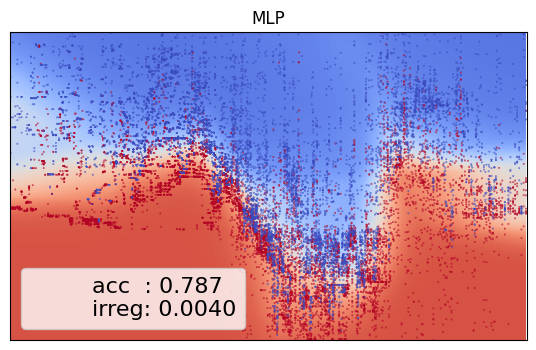

In [16]:
preds = mlp.predict_proba(x_grid)
preds = einx.rearrange('(h w) c -> h w c', preds, w=1000)

irreg_value = irregularity_value(preds)

result = {
    'model': 'MLP',
    'preds': preds[:, :, 0],
    'acc': score_test_mlp,
    'irreg': irreg_value
}

results.append(result)

make_boundary_plot(**result)

In [18]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(x_train, y_train)
score_test_rf = clf.score(x_test, y_test)

score_test_rf


0.8693558097531607

In [19]:
clf.feature_importances_

array([0.41942146, 0.58057854])

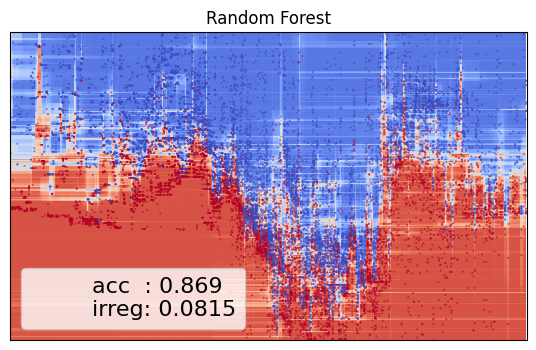

In [20]:
preds = clf.predict_proba(x_grid)
preds = einx.rearrange('(h w) c -> h w c', preds, w=1000)

irreg_value = irregularity_value(preds)

result = {
    'model': 'Random Forest',
    'preds': preds[:, :, 0],
    'acc': score_test_rf,
    'irreg': irreg_value
}

results.append(result)

make_boundary_plot(**result)

In [23]:
from tabularbench.core.dataset_split import make_dataset_split
from tabularbench.core.run_experiment import Data

def make_boundary_data(name: str):

    data = Data.from_standard_datasplits(x_train, x_val, x_test, y_train, y_val, y_test, cfg.task)

    model = get_model(cfg, data.x_train_cut, data.y_train_cut, categorical_indicator)
    trainer = get_trainer(cfg, model, dataset.n_classes, feature_names=["0", "1"])
    trainer.train(data.x_train_cut, data.y_train_cut, data.x_val_earlystop, data.y_val_earlystop)
    prediction_metrics_test = trainer.test(data.x_train_and_val, data.y_train_and_val, data.x_test, data.y_test)

    score_test = prediction_metrics_test.score

    preds_pfn_raw = trainer.predict(x_train, y_train, x_grid)
    preds_pfn = einx.softmax('n [c]', preds_pfn_raw)
    preds_pfn = einx.rearrange('(h w) c -> h w c', preds_pfn, w=1000)

    irreg_value = irregularity_value(preds_pfn)

    return {
        'model': name,
        'preds': preds_pfn[:, :, 0],
        'acc': score_test,
        'irreg': irreg_value
    }

2024-08-06 14:54:02.262 | INFO     | tabularbench.core.trainer_finetune:train:83 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.7158 | Val score: 0.4870
2024-08-06 14:54:03.239 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 001 | Train loss: 0.7124 | Train score: 0.5069 | Val loss: 0.6298 | Val score: 0.7080
2024-08-06 14:54:04.085 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 002 | Train loss: 0.6356 | Train score: 0.6919 | Val loss: 0.5765 | Val score: 0.7380


2024-08-06 14:54:04.933 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 003 | Train loss: 0.5898 | Train score: 0.7225 | Val loss: 0.5462 | Val score: 0.7380
2024-08-06 14:54:05.782 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 004 | Train loss: 0.5510 | Train score: 0.7400 | Val loss: 0.5306 | Val score: 0.7380
2024-08-06 14:54:06.631 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 005 | Train loss: 0.5357 | Train score: 0.7381 | Val loss: 0.5220 | Val score: 0.7385
2024-08-06 14:54:07.480 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 006 | Train loss: 0.5468 | Train score: 0.7250 | Val loss: 0.5153 | Val score: 0.7425
2024-08-06 14:54:08.329 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 007 | Train loss: 0.5247 | Train score: 0.7412 | Val loss: 0.5087 | Val score: 0.7470
2024-08-06 14:54:09.179 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 008 | Train loss: 0.5049 | Train sco

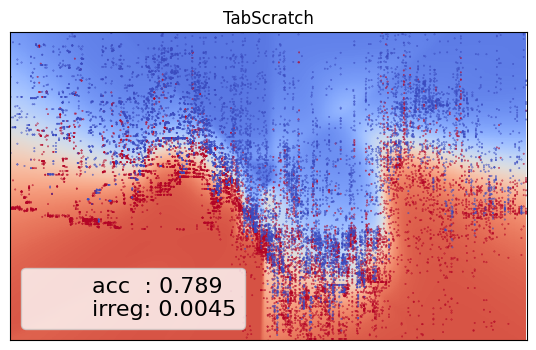

In [24]:
cfg.hyperparams['path_to_weights'] = None
cfg.hyperparams['use_pretrained_weights'] = False
cfg.hyperparams['max_epochs'] = 1000
cfg.hyperparams['dim'] = 512
cfg.model_name = ModelName.FOUNDATION

result = make_boundary_data("TabScratch")
results.append(result)
make_boundary_plot(**result)

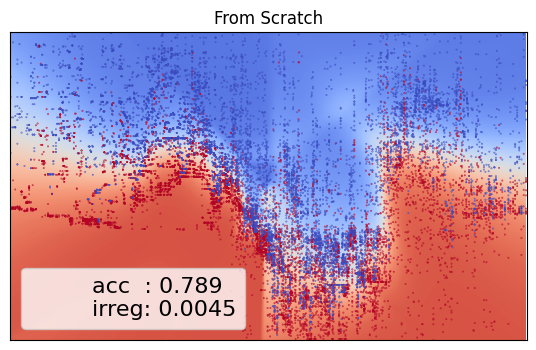

: 

In [26]:
result['model'] = 'From Scratch'
make_boundary_plot(**result)

2024-04-15 13:19:27.751 | INFO     | tabularbench.core.trainer_finetune:train:81 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.4283 | Val score: 0.7955


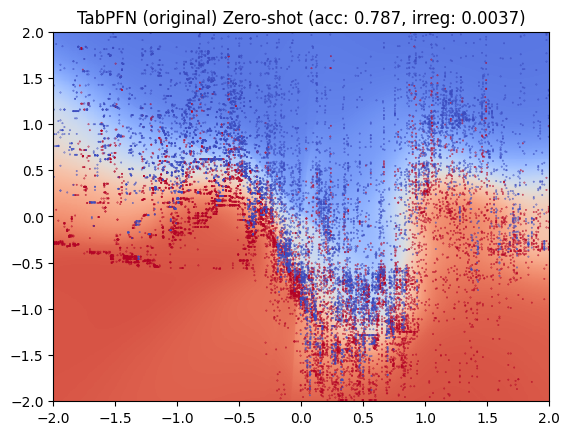

In [14]:
cfg.hyperparams['use_pretrained_weights'] = True
cfg.hyperparams['path_to_weights'] = tabpfn_weights
cfg.hyperparams['max_epochs'] = 0
cfg.hyperparams['dim'] = 512
cfg.model_name = ModelName.TABPFN

result = make_boundary_data("TabPFN (original) Zero-shot")
results.append(result)
make_boundary_plot(**result)

2024-04-15 13:20:28.994 | INFO     | tabularbench.core.trainer_finetune:train:81 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.4503 | Val score: 0.7780
2024-04-15 13:20:30.158 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 001 | Train loss: 0.4218 | Train score: 0.8100 | Val loss: 0.4500 | Val score: 0.7780
2024-04-15 13:20:31.236 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 002 | Train loss: 0.4371 | Train score: 0.7987 | Val loss: 0.4473 | Val score: 0.7830
2024-04-15 13:20:32.307 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 003 | Train loss: 0.4445 | Train score: 0.7881 | Val loss: 0.4413 | Val score: 0.7875
2024-04-15 13:20:33.381 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 004 | Train loss: 0.4096 | Train score: 0.8100 | Val loss: 0.4394 | Val score: 0.7860
2024-04-15 13:20:34.461 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 005 | Train loss: 0.4020 | Train sco

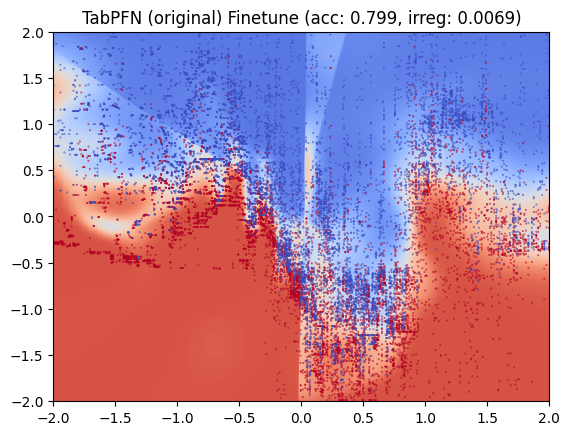

In [15]:
cfg.hyperparams['max_epochs'] = 300

result = make_boundary_data("TabPFN (original) Finetune")
results.append(result)
make_boundary_plot(**result)

2024-04-15 13:23:35.993 | INFO     | tabularbench.core.trainer_finetune:train:81 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.4698 | Val score: 0.7655


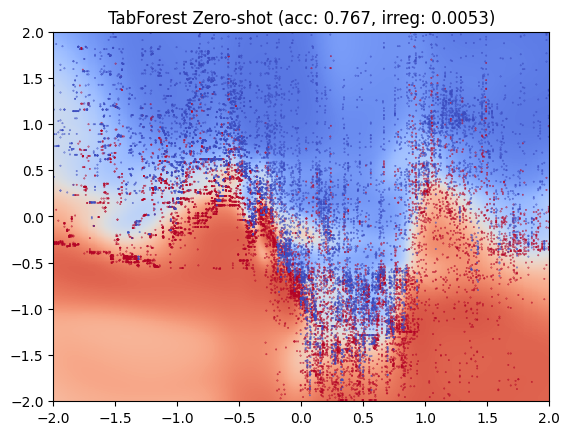

In [16]:
cfg.model_name = ModelName.FOUNDATION
cfg.hyperparams['path_to_weights'] = foundation_forest_weights
cfg.hyperparams['max_epochs'] = 0
cfg.hyperparams['dim'] = 512

result = make_boundary_data("TabForest Zero-shot")
results.append(result)
make_boundary_plot(**result)

2024-04-15 13:40:29.925 | INFO     | tabularbench.core.trainer_finetune:train:81 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.4494 | Val score: 0.7795
2024-04-15 13:40:31.251 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 001 | Train loss: 0.4815 | Train score: 0.7712 | Val loss: 0.4394 | Val score: 0.7805
2024-04-15 13:40:32.599 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 002 | Train loss: 0.4585 | Train score: 0.7675 | Val loss: 0.4232 | Val score: 0.8105
2024-04-15 13:40:33.941 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 003 | Train loss: 0.4526 | Train score: 0.7875 | Val loss: 0.4186 | Val score: 0.8140
2024-04-15 13:40:35.270 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 004 | Train loss: 0.4598 | Train score: 0.7906 | Val loss: 0.4144 | Val score: 0.8135
2024-04-15 13:40:36.621 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 005 | Train loss: 0.4518 | Train sco

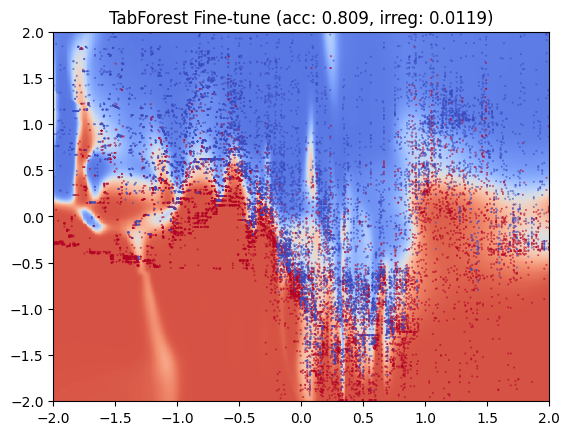

In [23]:
cfg.model_name = ModelName.FOUNDATION
cfg.hyperparams['path_to_weights'] = foundation_forest_weights
cfg.hyperparams['max_epochs'] = 300
cfg.hyperparams['dim'] = 512

result = make_boundary_data("TabForest Fine-tune")
results.append(result)
make_boundary_plot(**result)

2024-04-15 13:28:01.888 | INFO     | tabularbench.core.trainer_finetune:train:81 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.4439 | Val score: 0.7855


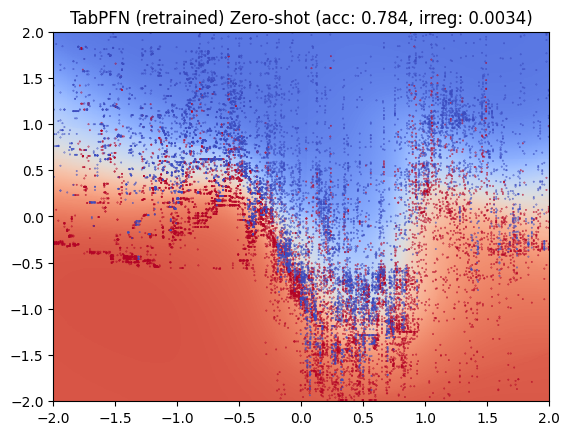

In [18]:
cfg.hyperparams['path_to_weights'] = foundation_pfn_weights
cfg.hyperparams['max_epochs'] = 0


result = make_boundary_data("TabPFN (retrained) Zero-shot")
results.append(result)
make_boundary_plot(**result)

2024-04-15 13:29:19.538 | INFO     | tabularbench.core.trainer_finetune:train:81 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.4508 | Val score: 0.7820
2024-04-15 13:29:20.924 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 001 | Train loss: 0.4382 | Train score: 0.7987 | Val loss: 0.4505 | Val score: 0.7825
2024-04-15 13:29:22.306 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 002 | Train loss: 0.4725 | Train score: 0.7844 | Val loss: 0.4481 | Val score: 0.7795
2024-04-15 13:29:23.693 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 003 | Train loss: 0.4692 | Train score: 0.7681 | Val loss: 0.4458 | Val score: 0.7825
2024-04-15 13:29:25.081 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 004 | Train loss: 0.4553 | Train score: 0.7894 | Val loss: 0.4449 | Val score: 0.7895
2024-04-15 13:29:26.471 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 005 | Train loss: 0.4257 | Train sco

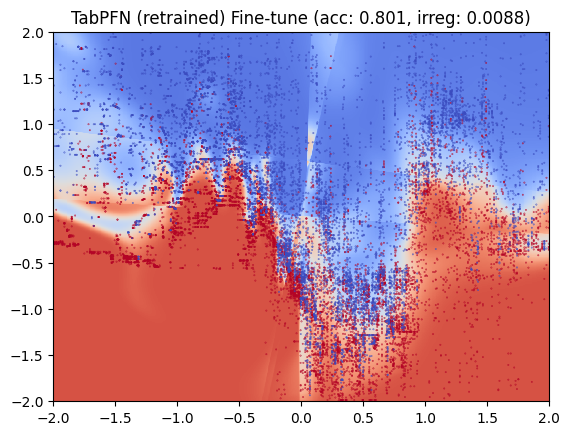

In [19]:
cfg.hyperparams['max_epochs'] = 300

result = make_boundary_data("TabPFN (retrained) Fine-tune")
results.append(result)
make_boundary_plot(**result)

2024-04-15 13:33:37.269 | INFO     | tabularbench.core.trainer_finetune:train:81 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.4305 | Val score: 0.7975
2024-04-15 13:33:38.088 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 001 | Train loss: 0.4395 | Train score: 0.7756 | Val loss: 0.4179 | Val score: 0.7960
2024-04-15 13:33:38.903 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 002 | Train loss: 0.4531 | Train score: 0.7781 | Val loss: 0.4181 | Val score: 0.8055
2024-04-15 13:33:39.582 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 003 | Train loss: 0.4567 | Train score: 0.7831 | Val loss: 0.4174 | Val score: 0.8060
2024-04-15 13:33:40.401 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 004 | Train loss: 0.4336 | Train score: 0.7812 | Val loss: 0.4171 | Val score: 0.8070
2024-04-15 13:33:41.222 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 005 | Train loss: 0.4573 | Train sco

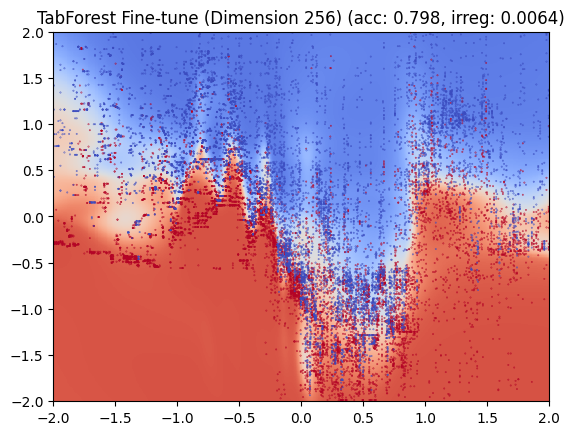

In [20]:
cfg.hyperparams['path_to_weights'] = foundation_forest_256_weights
cfg.hyperparams['max_epochs'] = 300
cfg.hyperparams['dim'] = 256

result = make_boundary_data("TabForest Fine-tune (Dimension 256)")
results.append(result)
make_boundary_plot(**result)

2024-04-15 13:35:57.442 | INFO     | tabularbench.core.trainer_finetune:train:81 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.4405 | Val score: 0.7885
2024-04-15 13:35:58.096 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 001 | Train loss: 0.4621 | Train score: 0.7775 | Val loss: 0.4301 | Val score: 0.7905
2024-04-15 13:35:58.755 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 002 | Train loss: 0.4507 | Train score: 0.7744 | Val loss: 0.4299 | Val score: 0.7985
2024-04-15 13:35:59.412 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 003 | Train loss: 0.4458 | Train score: 0.7837 | Val loss: 0.4362 | Val score: 0.7855
2024-04-15 13:36:00.029 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 004 | Train loss: 0.4398 | Train score: 0.7900 | Val loss: 0.4272 | Val score: 0.7980
2024-04-15 13:36:00.687 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 005 | Train loss: 0.4516 | Train sco

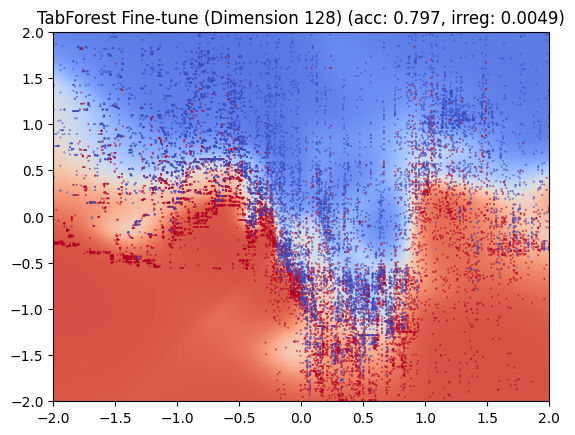

In [21]:
cfg.hyperparams['path_to_weights'] = foundation_forest_128_weights
cfg.hyperparams['max_epochs'] = 300
cfg.hyperparams['dim'] = 128

result = make_boundary_data("TabForest Fine-tune (Dimension 128)")
results.append(result)
make_boundary_plot(**result)

In [33]:
import pandas as pd

df = pd.DataFrame(results)
df

model  \
0                                  MLP   
1                        Random Forest   
2          TabPFN (original) Zero-shot   
3           TabPFN (original) Finetune   
4                  TabForest Zero-shot   
5                  TabForest Fine-tune   
6         TabPFN (retrained) Zero-shot   
7         TabPFN (retrained) Fine-tune   
8  TabForest Fine-tune (Dimension 256)   
9  TabForest Fine-tune (Dimension 128)   

                                               preds       acc     irreg  
0  [[0.9999509660502619, 0.9999507417645909, 0.99...  0.789233  0.003846  
1  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...  0.869356  0.081548  
2  [[0.9673891, 0.9672587, 0.9671742, 0.9671057, ...  0.787076  0.003721  
3  [[0.99919647, 0.9992105, 0.9992192, 0.999226, ...  0.799318  0.006860  
4  [[0.68220663, 0.682686, 0.6833042, 0.6839629, ...  0.766907  0.005255  
5  [[0.9881207, 0.9880812, 0.988042, 0.9880028, 0...  0.809402  0.011916  
6  [[0.97572404, 0.9757717, 0.9758016, 0.9758253,...  0.784016  0.003390  
7  [[0.99999654, 0.99999666, 0.99999666, 0.999996...  0.800672  0.008836  
8  [[0.9831487, 0.9833015, 0.9833983, 0.9834751, ...  0.797762  0.006378  
9  [[0.98352504, 0.98347616, 0.98342806, 0.983396...  0.796859  0.004903

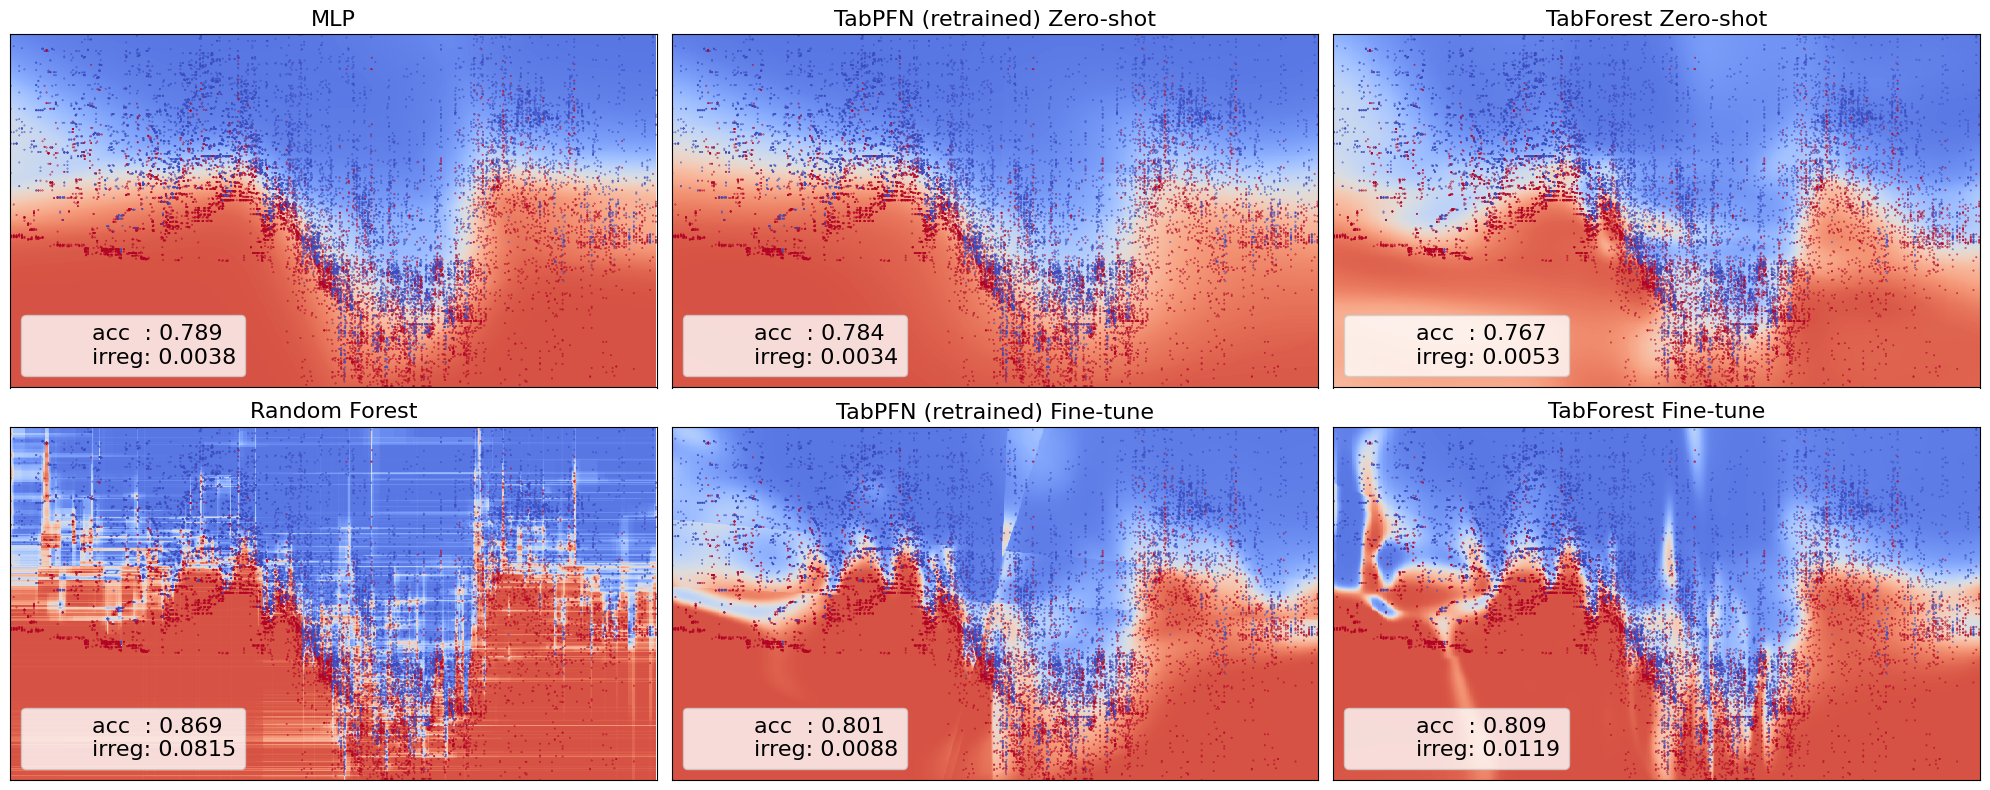

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches

fig, axs = plt.subplots(2, 3, figsize=(20, 8))

def plot_on_ax(ax, result):
    ax.pcolormesh(x_mesh1, x_mesh2, result['preds'], cmap=coolwarm_trunc)
    ax.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
    ax.set_ylim(-2, 2)
    ax.set_xlim(-2, 2)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    ax.set_title(f"{result['model']}", fontsize=16)
    r = matplotlib.patches.Rectangle((0,0), 0.2, 0.2, fill=False, edgecolor='none',  visible=False)
    ax.legend([r], [f"acc  : {result['acc']:.3f} \nirreg: {result['irreg']:.4f}"], loc='lower left', fontsize=16)

MLP = results[0]
plot_on_ax(axs[0, 0], MLP)

RF = results[1]
plot_on_ax(axs[1, 0], RF)

TabPFN_zeroshot = results[6]
plot_on_ax(axs[0, 1], TabPFN_zeroshot)

TabPFN_finetune = results[7]
plot_on_ax(axs[1, 1], TabPFN_finetune)

TabForest_zeroshot = results[4]
plot_on_ax(axs[0, 2], TabForest_zeroshot)

TabForest_finetune = results[5]
plot_on_ax(axs[1, 2], TabForest_finetune)

fig.tight_layout()

In [43]:
fig.savefig("boundary_plots.png", dpi=300)

In [44]:
import pickle

with open("boundary_results2.pkl", "wb") as f:
    pickle.dump(results, f)

In [13]:
import pickle

with open("boundary_results.pkl", "rb") as f:
    results = pickle.load(f)

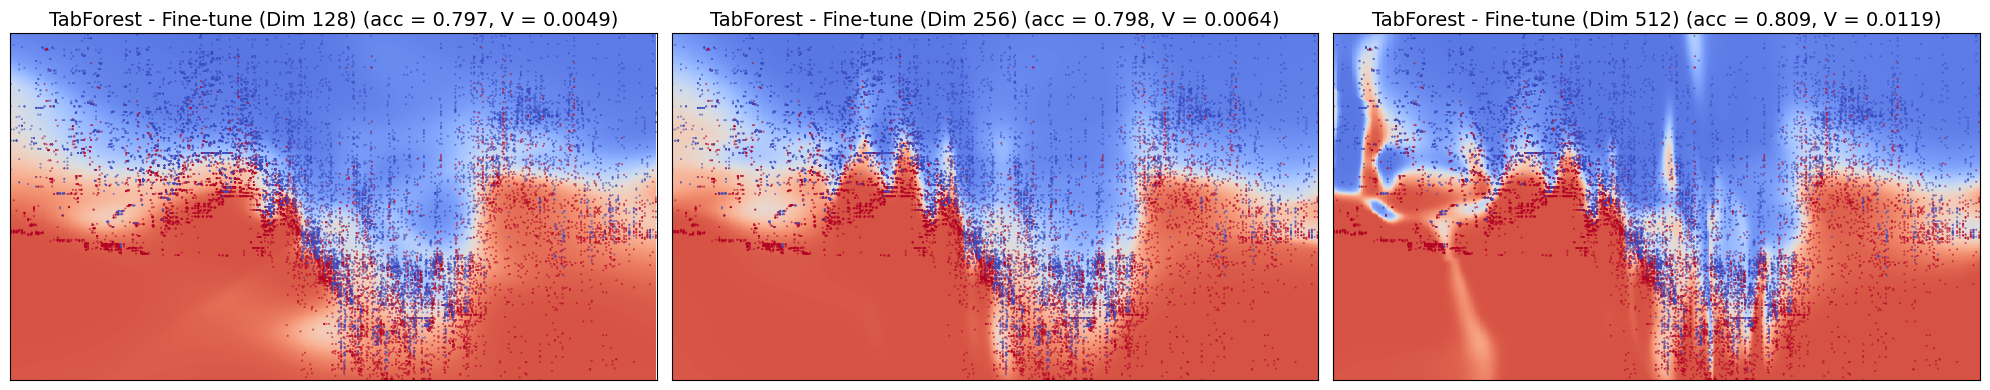

In [51]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4))

def plot_on_ax(ax, result, name):
    ax.pcolormesh(x_mesh1, x_mesh2, result['preds'], cmap=coolwarm_trunc)
    ax.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
    ax.set_ylim(-2, 2)
    ax.set_xlim(-2, 2)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    ax.set_title(f"{name} (acc = {result['acc']:.3f}, V = {result['irreg']:.4f})", fontsize=14)


TabForest_dim128 = results[9]
plot_on_ax(axs[0], TabForest_dim128, "TabForest - Fine-tune (Dim 128)")

TabForest_dim256 = results[8]
plot_on_ax(axs[1], TabForest_dim256, "TabForest - Fine-tune (Dim 256)")

TabForest_dim512 = results[5]
plot_on_ax(axs[2], TabForest_dim512, "TabForest - Fine-tune (Dim 512)")

fig.tight_layout()

In [52]:
fig.savefig("boundary_plots_dim.png", dpi=300)